In [1]:
import pandas as pd
from google.cloud import bigquery
from google.cloud.bigquery import job
from datetime import date, timedelta
# 판다스 엑셀 익스포트를 위한 라이브러리
import openpyxl


PROJECT = "ballosodeuk"
bq = bigquery.Client(project=PROJECT)

In [2]:

query = """  
(select 
    user_id, 
    total_asset,
    FLOOR(total_asset / 5000) * 5000 as asset_range_start,
    (FLOOR(total_asset / 5000) * 5000) + 2499 as asset_range_end,
    CONCAT(CAST(FLOOR(total_asset / 5000) * 5000 AS STRING), ' - ', 
          CAST((FLOOR(total_asset / 5000) * 5000) + 4999 AS STRING)) as asset_range
  from
    (select 
      user_id, 
      current_cash + current_shoji as total_asset, 
      row_number() over (partition by user_id order by register_dt desc) as rn
    from `dm.agg_user_cash_daily`)
  where rn = 1
  order by asset_range_start)"""

In [3]:
df = bq.query(query).to_dataframe()

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


In [ ]:
df = df.query("asset_range_start >= 0 & asset_range_start <= 34999")
grp = df.asset_range.unique()
grp

# 시각화를 위한 라이브러리 임포트
import matplotlib.pyplot as plt
import seaborn as sns

# 각 자산 범위별로 필터링하여 결과 확인 및 시각화
plt.figure(figsize=(15, 10))

for i, range_value in enumerate(grp):
    filtered_df = df.query(f"asset_range == '{range_value}'")
    user_ids_str = ", ".join([f"'{user_id}'" for user_id in filtered_df.user_id.tolist()])
    
    # 해당 범위의 사용자들의 구매 데이터 가져오기ㅠ
    tg_query = """
        SELECT 
            user_id, purchase        
        FROM dm.agg_user_cash_daily
        WHERE 1=1 
        and user_id IN ({})
            and purchase is not null
            and register_dt > "2024-12-31"
    """.format(user_ids_str)
    
    purchase_df = bq.query(tg_query).to_dataframe()
    
    if not purchase_df.empty:
        # 서브플롯 생성
        plt.subplot(len(grp), 1, i+1)
        
        # 히스토그램 그리기
        sns.histplot(purchase_df['purchase'], kde=True)
        
        # 평균, 중앙값, 최대값 계산
        mean_val = purchase_df['purchase'].mean()
        median_val = purchase_df['purchase'].median()
        max_val = purchase_df['purchase'].max()
        
        # 그래프 제목 및 레이블 설정
        plt.title(f'자산 범위: {range_value} (평균: {mean_val:.2f}, 중앙값: {median_val:.2f}, 최대값: {max_val:.2f})')
        plt.xlabel('구매 금액')
        plt.ylabel('빈도')
        
        # 통계 정보 출력
        print(f"자산 범위 {range_value}의 구매 통계:")
        print(f"사용자 수: {len(filtered_df)}")
        print(f"구매 데이터 수: {len(purchase_df)}")
        print(f"평균 구매액: {mean_val:.2f}")
        print(f"중앙값: {median_val:.2f}")
        print(f"최대값: {max_val:.2f}")
        print("-" * 50)

plt.tight_layout()
plt.show()

# 전체 데이터 저장
tg_query_all = """
    SELECT 
        user_id, purchase        
    FROM dm.agg_user_cash_daily
    WHERE 1=1 
        and user_id IN ({})
        and purchase is not null
        and register_dt > "2024-12-31"
""".format(", ".join([f"'{user_id}'" for user_id in df.user_id.tolist()]))
tg_df = bq.query(tg_query_all).to_dataframe()


BadRequest: 400 POST https://bigquery.googleapis.com/bigquery/v2/projects/ballosodeuk/jobs?prettyPrint=false: The query is too large. The maximum standard SQL query length is 1024.00K characters, including comments and white space characters.

Location: None
Job ID: 03b8cb98-aac8-484d-955e-231a331e5056


<Figure size 1080x720 with 0 Axes>

In [74]:
query = """
-- 자산 범위별 사용자의 구매 데이터를 조회하는 쿼리
WITH user_asset_ranges AS (
  SELECT 
    user_id, 
    total_asset,
    FLOOR(total_asset / 5000) * 5000 AS asset_range_start,
    (FLOOR(total_asset / 5000) * 5000) + 4999 AS asset_range_end,
    CONCAT(CAST(FLOOR(total_asset / 5000) * 5000 AS STRING), ' - ', 
           CAST((FLOOR(total_asset / 5000) * 5000) + 4999 AS STRING)) AS asset_range
  FROM (
    SELECT 
      user_id, 
      current_cash + current_shoji AS total_asset, 
      ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY register_dt DESC) AS rn
    FROM `dm.agg_user_cash_daily`
  )
  WHERE rn = 1
)
SELECT 
  uar.asset_range,
  uar.user_id,
  auc.purchase
FROM user_asset_ranges uar
JOIN `dm.agg_user_cash_daily` auc
  ON uar.user_id = auc.user_id
WHERE auc.purchase IS NOT NULL
  AND auc.register_dt > "2025-03-01"
  AND uar.asset_range_start >= 0 
  AND uar.asset_range_start <= 34999
ORDER BY uar.asset_range, uar.user_id"""

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opt

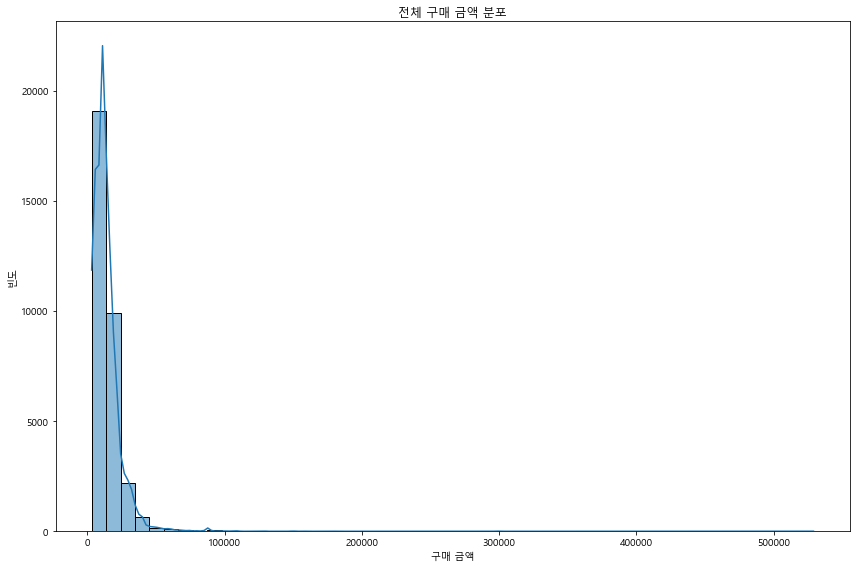

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

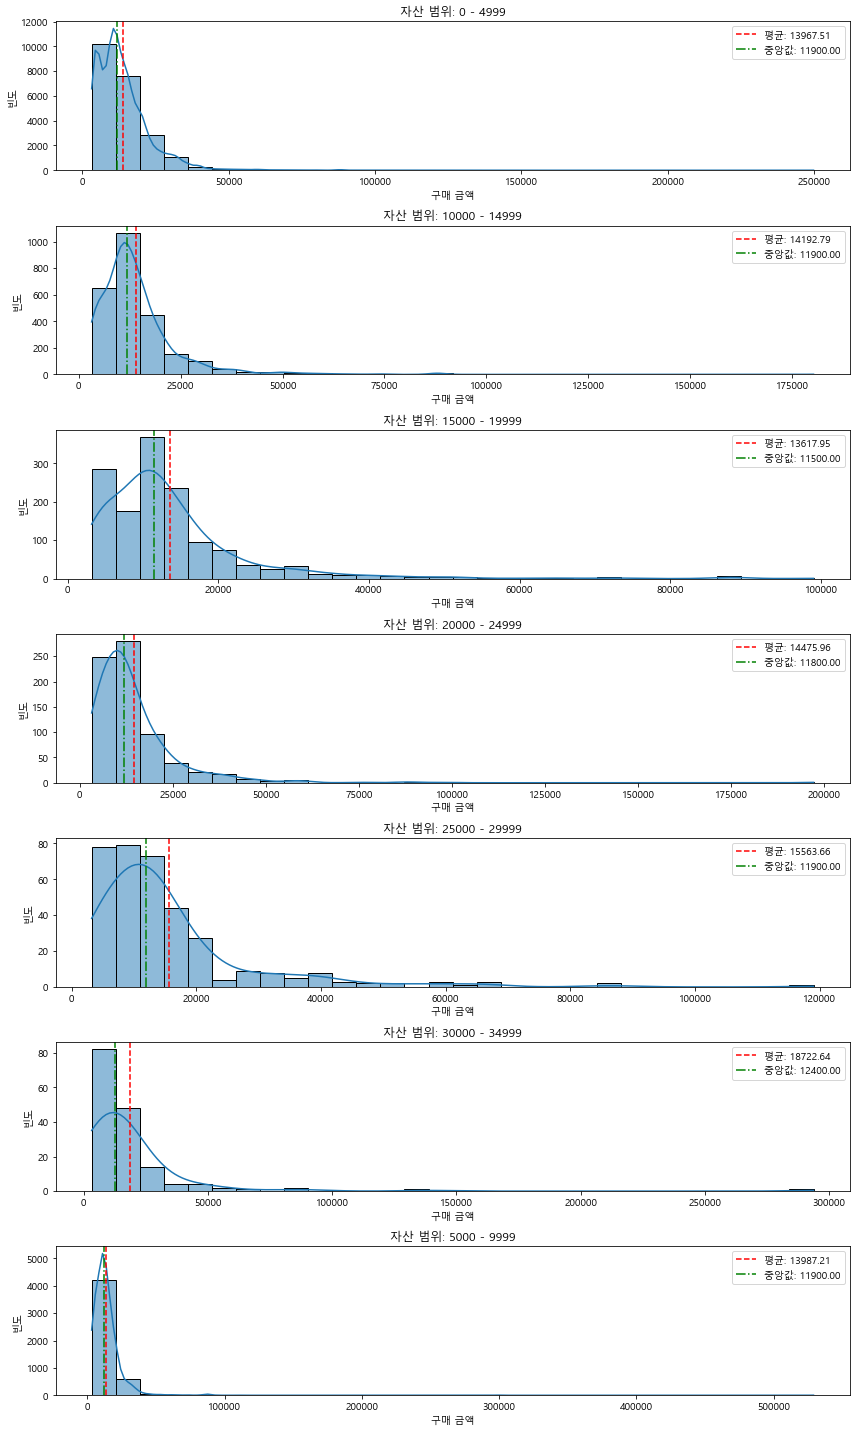

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


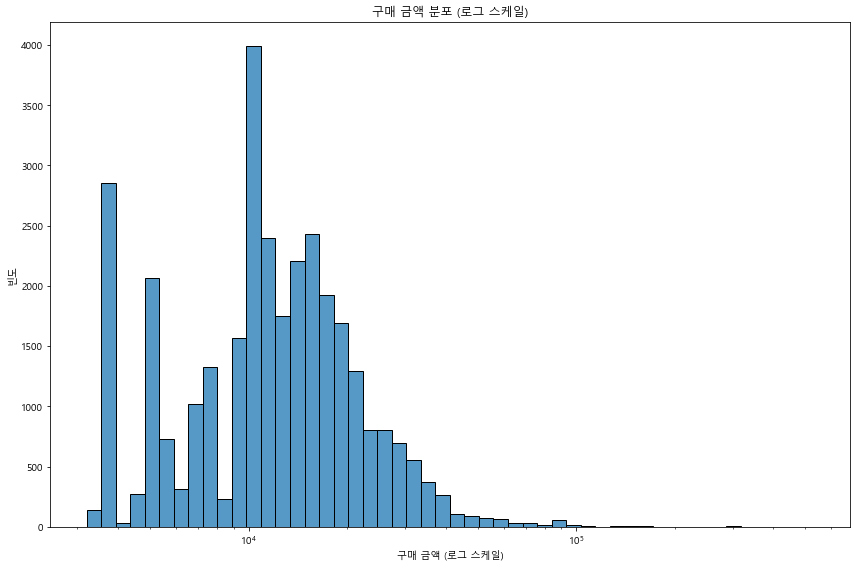

,count,mean,std,min,25%,50%,75%,max
asset_range,,,,,,,,
0 - 4999,22234.0,13967.507421,10146.144953,3200.0,7800.0,11900.0,17400.0,249800.0
10000 - 14999,2520.0,14192.785714,10340.242050,3200.0,8900.0,11900.0,16700.0,180200.0
15000 - 19999,1392.0,13617.952586,10494.957375,3200.0,7800.0,11500.0,15900.0,99000.0
20000 - 24999,725.0,14475.958621,12890.180974,3200.0,7800.0,11800.0,16900.0,197100.0
25000 - 29999,352.0,15563.664773,13862.383109,3200.0,7900.0,11900.0,16900.0,119000.0
30000 - 34999,159.0,18722.641509,27731.403678,3200.0,7800.0,12400.0,19800.0,293700.0
5000 - 9999,4876.0,13987.208778,13167.062272,3200.0,8037.5,11900.0,16900.0,529000.0


In [76]:
# # 쿼리 실행 및 데이터 가져오기
combined_df = bq.query(query).to_dataframe()

# 히스토그램으로 purchase 분포 확인
import matplotlib.pyplot as plt
import seaborn as sns

# 전체 구매 금액 히스토그램
plt.figure(figsize=(12, 8))
sns.histplot(combined_df['purchase'], kde=True, bins=50)
plt.title('전체 구매 금액 분포')
plt.xlabel('구매 금액')
plt.ylabel('빈도')
plt.tight_layout()
plt.show()

# 자산 범위별 히스토그램 (서브플롯)
fig, axes = plt.subplots(nrows=len(combined_df['asset_range'].unique()), figsize=(12, 20))
for i, (asset_range, group) in enumerate(combined_df.groupby('asset_range')):
    sns.histplot(group['purchase'], ax=axes[i], kde=True, bins=30)
    axes[i].set_title(f'자산 범위: {asset_range}')
    axes[i].set_xlabel('구매 금액')
    axes[i].set_ylabel('빈도')
    
    # 평균값과 중앙값 표시
    mean_val = group['purchase'].mean()
    median_val = group['purchase'].median()
    axes[i].axvline(mean_val, color='r', linestyle='--', label=f'평균: {mean_val:.2f}')
    axes[i].axvline(median_val, color='g', linestyle='-.', label=f'중앙값: {median_val:.2f}')
    axes[i].legend()
    
plt.tight_layout()
plt.show()

# 로그 스케일 히스토그램 (큰 값의 분포도 확인)
plt.figure(figsize=(12, 8))
sns.histplot(combined_df['purchase'], log_scale=True, bins=50)
plt.title('구매 금액 분포 (로그 스케일)')
plt.xlabel('구매 금액 (로그 스케일)')
plt.ylabel('빈도')
plt.tight_layout()
plt.show()

# 기본 통계량 확인
combined_df.groupby('asset_range')['purchase'].describe()

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opt

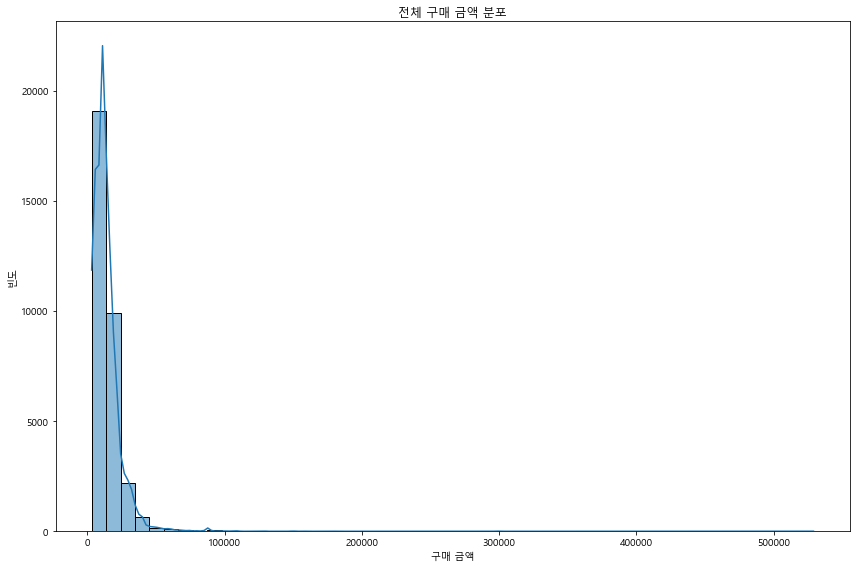

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

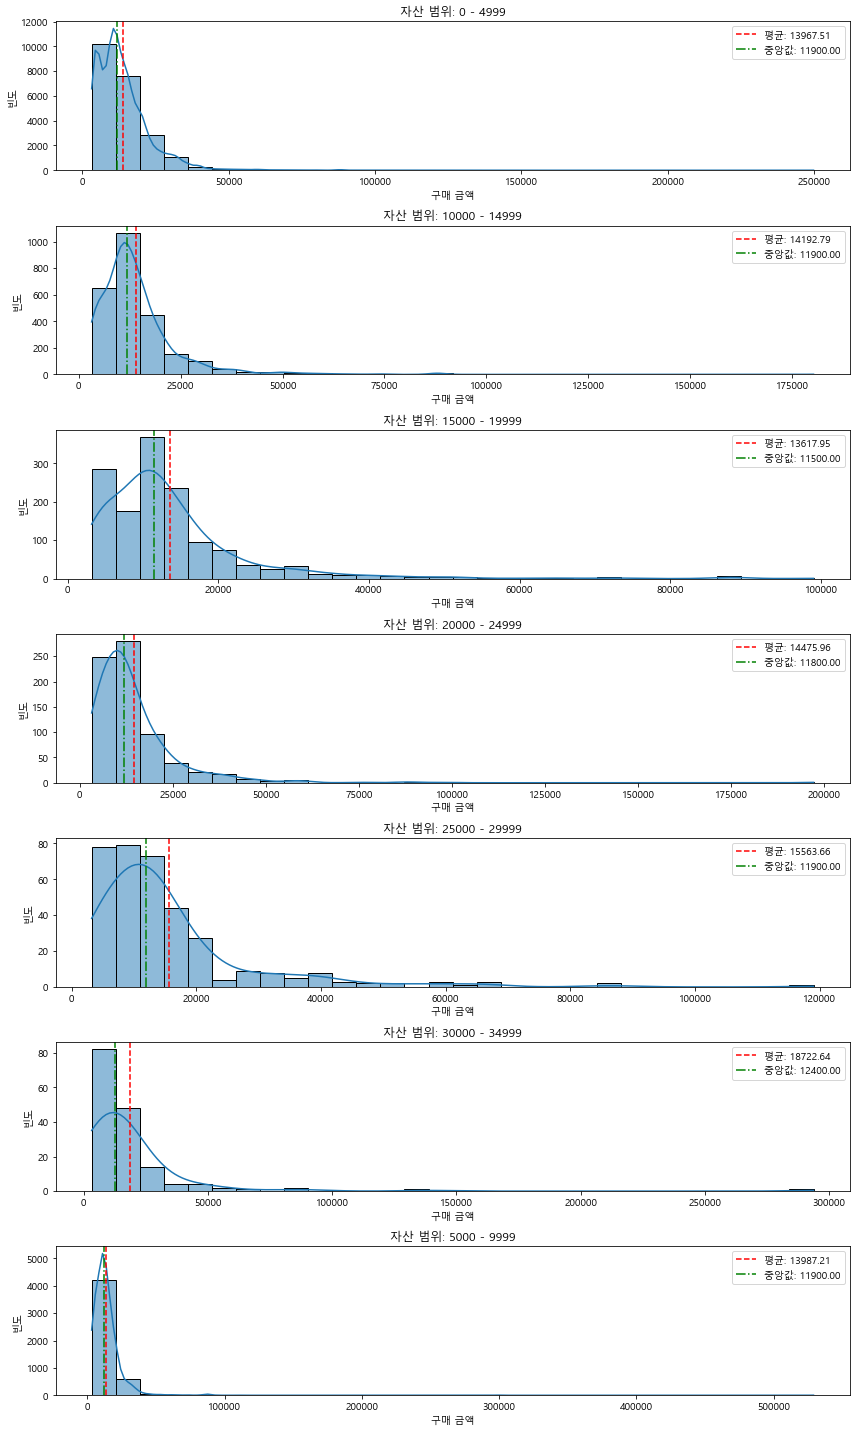

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


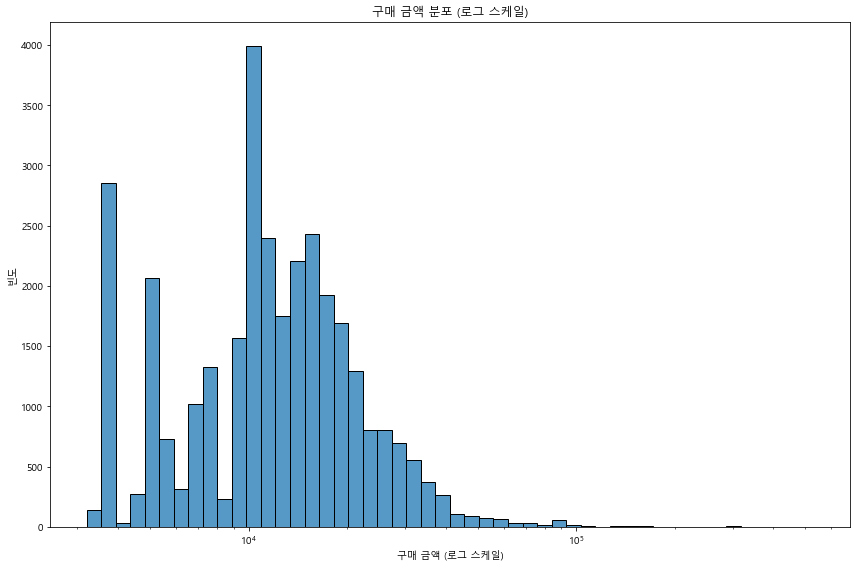

각 자산 범위별 지수분포 파라미터:


,count,mean,std,min,25%,50%,75%,max
asset_range,,,,,,,,
0 - 4999,22234.0,13967.507421,10146.144953,3200.0,7800.0,11900.0,17400.0,249800.0
10000 - 14999,2520.0,14192.785714,10340.242050,3200.0,8900.0,11900.0,16700.0,180200.0
15000 - 19999,1392.0,13617.952586,10494.957375,3200.0,7800.0,11500.0,15900.0,99000.0
20000 - 24999,725.0,14475.958621,12890.180974,3200.0,7800.0,11800.0,16900.0,197100.0
25000 - 29999,352.0,15563.664773,13862.383109,3200.0,7900.0,11900.0,16900.0,119000.0
30000 - 34999,159.0,18722.641509,27731.403678,3200.0,7800.0,12400.0,19800.0,293700.0
5000 - 9999,4876.0,13987.208778,13167.062272,3200.0,8037.5,11900.0,16900.0,529000.0


In [78]:
# # 쿼리 실행 및 데이터 가져오기
combined_df = bq.query(query).to_dataframe()

# 히스토그램으로 purchase 분포 확인
import matplotlib.pyplot as plt
import seaborn as sns

# 전체 구매 금액 히스토그램
plt.figure(figsize=(12, 8))
sns.histplot(combined_df['purchase'], kde=True, bins=50)
plt.title('전체 구매 금액 분포')
plt.xlabel('구매 금액')
plt.ylabel('빈도')
plt.tight_layout()
plt.show()

# 자산 범위별 히스토그램 (서브플롯)
fig, axes = plt.subplots(nrows=len(combined_df['asset_range'].unique()), figsize=(12, 20))
for i, (asset_range, group) in enumerate(combined_df.groupby('asset_range')):
    sns.histplot(group['purchase'], ax=axes[i], kde=True, bins=30)
    axes[i].set_title(f'자산 범위: {asset_range}')
    axes[i].set_xlabel('구매 금액')
    axes[i].set_ylabel('빈도')
    
    # 평균값과 중앙값 표시
    mean_val = group['purchase'].mean()
    median_val = group['purchase'].median()
    axes[i].axvline(mean_val, color='r', linestyle='--', label=f'평균: {mean_val:.2f}')
    axes[i].axvline(median_val, color='g', linestyle='-.', label=f'중앙값: {median_val:.2f}')
    axes[i].legend()
    
plt.tight_layout()
plt.show()

# 로그 스케일 히스토그램 (큰 값의 분포도 확인)
plt.figure(figsize=(12, 8))
sns.histplot(combined_df['purchase'], log_scale=True, bins=50)
plt.title('구매 금액 분포 (로그 스케일)')
plt.xlabel('구매 금액 (로그 스케일)')
plt.ylabel('빈도')
plt.tight_layout()
plt.show()

# 기본 통계량 확인
# 각 자산 범위별 지수분포 파라미터 도출
import numpy as np
from scipy import stats

exp_params = {}
for asset_range, group in combined_df.groupby('asset_range'):
    # 지수분포의 파라미터 lambda는 1/평균값
    mean_val = group['purchase'].mean()
    lambda_val = 1 / mean_val
    
    # 지수분포 적합도 검정
    _, p_value = stats.kstest(group['purchase'], 'expon', args=(0, mean_val))
    
    exp_params[asset_range] = {
        '평균': mean_val,
        '람다(λ)': lambda_val,
        'p-value': p_value,
        '샘플 수': len(group)
    }
    
# 결과를 데이터프레임으로 변환하여 출력
exp_params_df = pd.DataFrame(exp_params).T
print("각 자산 범위별 지수분포 파라미터:")
exp_params_df

# 기본 통계량도 함께 확인
combined_df.groupby('asset_range')['purchase'].describe()

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='purchase', ylabel='Count'>

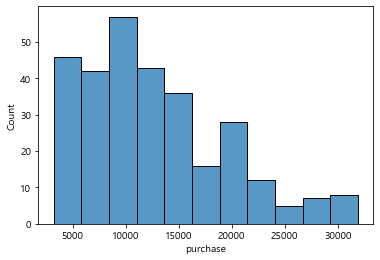

In [62]:
percentile_95 = np.percentile(combined_df['purchase'], 95)
filtered_df_no_outliers = filtered_df[filtered_df['purchase'] <= percentile_95]
sns.histplot(filtered_df_no_outliers['purchase'], kde=False)

# percentile_95

In [65]:
combined_df.query('purchase <= 30000').sort_values(by='purchase', ascending=True).purchase.value_counts()

purchase
3900.0     5125
9900.0     3377
11900.0    2362
12900.0    2103
5200.0     1845
           ... 
23840.0       1
12790.0       1
13250.0       1
13350.0       1
16450.0       1
Name: count, Length: 344, dtype: int64

In [61]:
filtered_df[filtered_df['purchase'] <= percentile_95].sort_values(by='purchase', ascending=True).purchase.value_counts()


purchase
3900.0     30
9900.0     14
8900.0     12
6900.0     12
7800.0     11
           ..
8800.0      1
19100.0     1
19300.0     1
19400.0     1
19600.0     1
Name: count, Length: 97, dtype: int64